# Fuzzy Time Series - Particle Swarm Optimization - Fuzzy Order

By DIMAS ANGGA WIJAYA MUKTI

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
class FTS_PSOorder:
    X = []
    V = []
    error_n = []
    w_min = 0.4
    w_max = 0.9
    Pbest = 0
    Gbest = 0
    #Membuat fungsi inisialisasi parameter
    def __init__(self, dataset, n_min, n_max, D1, D2, U, c1, c2, max_m, max_ptr, max_itr, V_min, V_max):
        self.dataset = dataset
        self.n_min = n_min
        self.n_max = n_max
        self.D1 = D1
        self.D2 = D2
        self.U = np.array([self.dataset.min()-self.D1,self.dataset.max()+self.D2])
        self.c1 = c1
        self.c2 = c2
        self.max_m = max_m
        self.max_ptr = max_ptr
        self.max_itr = max_itr
        self.V_min = V_min
        self.V_max = V_max
    
    #Membuat fungsi utama
    def Main_Process(self):
        Gbest_n = []
        Pbest_n = []
        #Looping jumlah partisi
        for n in range(self.n_min,self.n_max+1):
            self.X = []
            self.V = []
            for i in range(0,self.max_ptr):
                x = []
                for j in range(0,n-1):
                    y = self.U[0] + np.random.rand() * (self.U[1]-self.U[0])
                    x.append(y)
                x.sort()
                self.X.append(x)
            self.V = np.zeros((self.max_ptr,n-1))
                
            itr = 1
            Gbest_list_itr = []
            
            #Looping iterasi
            while itr <= self.max_itr:
                Partners = []
                list_cost = []
                
                #Looping jumlah partikel
                for k in range (0,self.max_ptr):
                    #Determine midpoint values
                    N = []
                    M = self.X[k].copy()
                    M.insert(0,self.U[0])
                    M.append(self.U[1])
                    for i in range(1,len(M)):
                        e = float((M[i-1]) + M[i])/2
                        N.append(e)

                    #Menghitung LHS untuk FLR
                    LHS=[]
                    for i in range(0,len(self.dataset)):
                        if self.dataset[i] >= self.U[0] and self.dataset[i] <= self.X[k][0]:
                            LHS.append("A1")
                        for j in range(3,n+1):
                            if self.dataset[i] > self.X[k][n-j] and self.dataset[i] <= self.X[k][n-j+1]:
                                LHS.append('A'+str(n-j+2))
                        if self.dataset[i] > self.X[k][n-2] and self.dataset[i] <= self.U[1]:
                            LHS.append('A'+str(n))
                    
                    #Menghitung FLR
                    list_MSE = []
                    data_forecast = []
                    for m in range(1,self.max_m+1): 
                        RHS = LHS.copy()
                        FLR = []
                        for i in range(m,len(self.dataset)):
                            b = LHS[i-1]
                            c = b
                            for s in range(2,m+1):
                                c = LHS[i-s] + "," + c 
                            a = c + " --> " + RHS[i]
                            FLR.append(a)
                    
                        #Menghitug FLRG
                        FLRG_value = []
                        FLRG_col1 = []
                        FLRG_col2 = []
                        for i in range(0,len(FLR)):
                            FLRG_rep = FLR[i].replace(' --> ',';')
                            FLRG_rep_split = FLRG_rep.split(';')
                            FLRG_value.append(FLRG_rep_split)
                        for i in range(0,len(FLRG_value)):
                            FLRG_col1.append(FLRG_value[i][0])
                        for i in range(0,len(FLRG_value)):
                            FLRG_col2.append(FLRG_value[i][1])
                        
                        tp_FLRG = {'CurrentState':FLRG_col1,'NextState':FLRG_col2}
                        df_FLRG = pd.DataFrame(tp_FLRG)
                        df_FLRG_sort = df_FLRG.sort_values(by=["CurrentState", "NextState"])
                        a11_new = []
                        a11_rep = []

                        for i in df_FLRG_sort['NextState']:
                            a11_rep.append(i.replace('A',''))
                        ind_list = [int(i) for i in a11_rep]
                        for i in range(0,len(ind_list)):
                            a11_new.append(N[ind_list[i]-1])
                        df_FLRG_sort['Midpoint'] = a11_new
                        fct = df_FLRG_sort.drop_duplicates().groupby(df_FLRG_sort['CurrentState']).mean()
                        aoi = np.array(fct.index)
                        aio = fct['Midpoint'].values
                        fc = {'CurrentState':aoi,'Midpoint':aio}
                        df_fc = pd.DataFrame(fc)
                        
                        #Menghitung nilai peramalan
                        forecast = []
                        for i in FLRG_col1:
                            forecast.append(df_fc['Midpoint'][df_fc.loc[df_fc['CurrentState'] == i].index.values[0]])

                        #Menghitung MSE partikel ke-k dan orde ke-m
                        MSE_value = []
                        list_forecast = []
                        for i in range(0,len(forecast)):
                            Err = (self.dataset[i+m]-forecast[i])**2
                            MSE_value.append(Err)
                        MSE = sum(MSE_value)/len(forecast)
                        list_MSE.append(MSE)

                        data_forecast.append(forecast)
                        
                    #Memperbarui Pbest dan orde ke-m pada setiap partikel
                    Partners.append(n)
                    Partners.append(itr)
                    Partners.append(k+1)
                    Partners.append(self.X[k])
                    Partners.append(list_MSE.index(min(list_MSE))+1) 
                    Partners.append(data_forecast[list_MSE.index(min(list_MSE))])
                    Partners.append(min(list_MSE))
                    list_cost.append(Partners)
                    list_MSE = []
                    Partners = []

                if itr == 1:
                    Pbest_itr = list_cost.copy()
                           
                elif itr > 1:
                    for i in range(0,self.max_ptr):
                        if list_cost[i][6] < Pbest_itr[i][6]:
                            Pbest_itr[i] = list_cost[i]
                
                Gbest_list = []
                for i in range(0,len(Pbest_itr)):
                    Gbest_list.append(Pbest_itr[i][6])
                Gbest_list_itr.append(Pbest_itr[Gbest_list.index(min(Gbest_list))])
                
                #Memperbarui posisi dan kecepatan partikel ke-k 
                w = self.w_max - (itr * (self.w_max - self.w_min))/self.max_itr
                
                for k in range(0,self.max_ptr):
                    np.random.seed(itr)
                    br1 = np.random.uniform()
                    br2 = np.random.uniform()
                    self.V[k] = w * np.array(self.V[k]) + self.c1 * br1 * (np.array(Pbest_itr[k][3]) - np.array(self.X[k])) + self.c2 * br2 * (np.array(Gbest_list_itr[itr-1][3]) - np.array(self.X[k]))
                    for i in range(0,len(self.V[k])):
                        if self.V[k][i] < self.V_min:
                            self.V[k][i] = self.V_min
                        if self.V[k][i] > self.V_max:
                            self.V[k][i] = self.V_max
                    self.X[k] = list(np.array(self.X[k]) + self.V[k]) 
                    self.X[k].sort()
                
                itr = itr + 1
            
            #Mencari gbest setelah maksimum iterasi
            OH = []
            par = []
            for i in range(0,len(Gbest_list_itr)):
                OH.append(Gbest_list_itr[i][6])
            Gbest_n.append(Gbest_list_itr[OH.index(min(OH))])
            Pbest_n.append(Pbest_itr)
            par.append(n)
            par.append(OH)
            self.error_n.append(par)
            
            print(Pbest_n)
            print(Gbest_n)
        
        #Mencari gbest setelah mencapai jumlah partisi
        OI = []
        for i in range(0,len(Gbest_n)):
            OI.append(Gbest_n[i][6])
        self.Gbest = Gbest_n[OI.index(min(OI))]
        self.Pbest = Pbest_n[OI.index(min(OI))]
        
        return '<main_process success>'
    
    #Membuat fungsi memanggil nilai Pbest
    def Pbest_show(self):
        return 'Hasil Pbest yang diperoleh adalah sebagai berikut: ', self.Pbest
    
    #Membuat fungsi memanggil nilai gbest
    def Gbest_show(self):
        return 'Hasil Gbest yang diperoleh adalah sebagai berikut: ', self.Gbest
    
    #Membuat fungsi untuk Forecasting Plot
    def Forecasting_Plot(self):
        for i in range(1,self.max_m+1):
            if self.Gbest[4] == i:
                indeks = []
                for j in range(1,len(self.dataset)-self.Gbest[4]+1):
                    indeks.append(j)

                fig, ax = plt.subplots()
                ax.set_xlim(1,125)

                ax.plot(indeks, self.dataset[i:len(self.dataset)])
                ax.plot(indeks, self.Gbest[5])

                ax.set_title('Actual Data vs Forecasting Data')
                ax.set_xlabel('Periode (hari)')
                ax.set_ylabel('Nilai Saham')

                fig.legend(['Actual Data','Forecasting Data'], loc = 'lower right')
                plt.show()
        return '<Forecasting_Plot success>'
    
    #Membuat fungsi memanggil nilai MAPE
    def MAPE_Value(self):
        mm = []
        for i in range(1,self.max_m+1):
            if self.Gbest[4] == i:
                for j in range(0,len(self.Gbest[5])):
                    absm = abs((self.dataset[j+i]-self.Gbest[5][j])/self.dataset[j+i])
                    mm.append(absm)
                mape = (sum(mm)/len(self.Gbest[5]))*100
        return "Nilai MAPE yang diperoleh: ","%.2f%%" % mape
    
    #Membuat fungsi MSE Plot
    def MSE_Plot(self):
        fig, ax = plt.subplots()
        legend = []
        for i in range(0,len(self.error_n)):
            legend.append(str(self.error_n[i][0]))
        
        for i in range(0,len(self.error_n)):
            ax.plot(np.arange(len(self.error_n[i][1])),self.error_n[i][1])

        ax.set_title("Nilai MSE pada Setiap Iterasi")
        ax.set_xlabel("Iterasi")
        ax.set_ylabel("MSE")

        fig.legend(legend)
        plt.show()
        return '<MSE_Plot success>'

In [6]:
df=pd.read_excel('D:\TA\Data2.xlsx')
data = df["Harga Penutupan"]

In [7]:
Peramalan = FTS_PSOorder(data,20,30,10,20,0,2,2,5,10,50,-10,10)

In [8]:
Peramalan.Main_Process()

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

[[[20, 50, 1, [4108.473313759726, 4202.7189781315765, 4238.3443051828, 4285.849246278771, 4326.597602641214, 4375.6912513833995, 4421.645636710203, 4466.32314091512, 4508.090746389306, 4550.604138361839, 4607.21527455292, 4653.723014484842, 4676.547148640094, 4735.000862430196, 4812.137582264385, 4861.597601374706, 4914.2781865354955, 4954.4316798028485, 4960.960698327926], 5, [4262.096775730785, 4351.144427012307, 4306.223424459992, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4398.668444046802, 4351.144427012307, 4351.144427012307, 4351.144427012307, 4398.668444046802, 4306.223424459992, 4351.144427012307, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4351.144427012307, 4306.223424459992, 4262.096775730785, 4306.223424459992, 4306.223424459992, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4262.096775730785, 4351.144427012307, 4398.668444046802, 4443.984388812662, 4578.90970645738, 4578.90970645738, 4443.984388812662, 4578.90970645

'<main_process success>'

In [9]:
Peramalan.Pbest_show()

('Hasil Pbest yang diperoleh adalah sebagai berikut: ',
 [[30,
   42,
   1,
   [4137.556842108894,
    4177.541524183472,
    4239.737410992015,
    4284.8197390948135,
    4315.103630971216,
    4340.557414808444,
    4379.317752851841,
    4403.9055571219815,
    4426.865024358813,
    4449.169861906964,
    4471.190526115187,
    4491.361352894951,
    4520.677858777923,
    4530.026330867285,
    4579.525198024748,
    4583.902690776902,
    4605.05656362372,
    4627.7159254651415,
    4663.89881211249,
    4676.175037599495,
    4693.029596847165,
    4738.283347685701,
    4756.314817408677,
    4776.738857121148,
    4831.041049476185,
    4861.237410563857,
    4895.593177920613,
    4952.962223314924,
    4961.803438150432],
   5,
   [4262.278575043414,
    4327.83052288983,
    4327.83052288983,
    4359.937583830142,
    4359.937583830142,
    4359.937583830142,
    4391.611654986911,
    4391.611654986911,
    4359.937583830142,
    4359.937583830142,
    4359.937583830142

In [10]:
Peramalan.Gbest_show()

('Hasil Gbest yang diperoleh adalah sebagai berikut: ',
 [30,
  50,
  5,
  [4136.20228085141,
   4178.771894958883,
   4238.509265386687,
   4286.311840516175,
   4315.129343270873,
   4338.184009853807,
   4379.597655897262,
   4406.721381402377,
   4425.97000909818,
   4449.121658758218,
   4474.29248275147,
   4492.816319996659,
   4519.618170258733,
   4531.143129549766,
   4579.431436318504,
   4583.864095944002,
   4606.368880979973,
   4630.275681818354,
   4659.931749031144,
   4674.197293969093,
   4691.794624492502,
   4735.160789854529,
   4755.333977823305,
   4779.943962424646,
   4829.210190503868,
   4860.297573035283,
   4898.480595636656,
   4952.838881317731,
   4961.859513029721],
  5,
  [4262.410552951431,
   4326.656676562339,
   4326.656676562339,
   4358.890832875534,
   4358.890832875534,
   4358.890832875534,
   4393.15951864982,
   4393.15951864982,
   4358.890832875534,
   4358.890832875534,
   4358.890832875534,
   4416.345695250278,
   4300.720591893523,
  

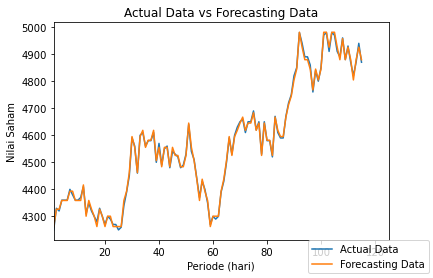

'<Forecasting_Plot success>'

In [11]:
Peramalan.Forecasting_Plot()

In [12]:
Peramalan.MAPE_Value()

('Nilai MAPE yang diperoleh: ', '0.15%')

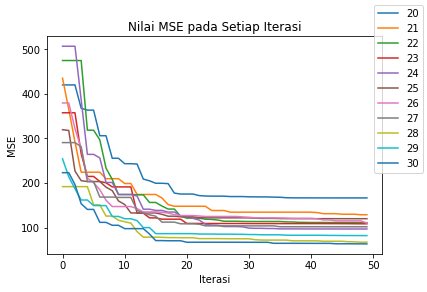

'<MSE_Plot success>'

In [13]:
Peramalan.MSE_Plot()

In [14]:
Peramalan.U

array([4100, 5000])